In our project, we use deep learning to predict the early universe from its later state. To evaluate our predictions, we use a three-panel plot:

1. First Panel: Shows our model's guess of the early universe.
2. Second Panel: Compares this guess with the actual early universe, highlighting where the model might be wrong.
3. Third Panel: Tests if we can use the errors from the second panel to improve predictions in a new situation.

These plots help us understand and improve our model's ability to recreate the universe's beginnings.

### Loading necessary libraries


In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')
from gravitational_influence_voxel_manipulation import remove_center_and_fill

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(-629.69934, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-28 23:08:12.613903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 23:08:13.040984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


#### Setting the seed

In [4]:
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [5]:
# Generating 2 random samples
# These samples are completely unseen by the model - VNET (trained on 100K+ samples)

data = np.load('../generated_data/two_samples.npy')

In [6]:
# split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

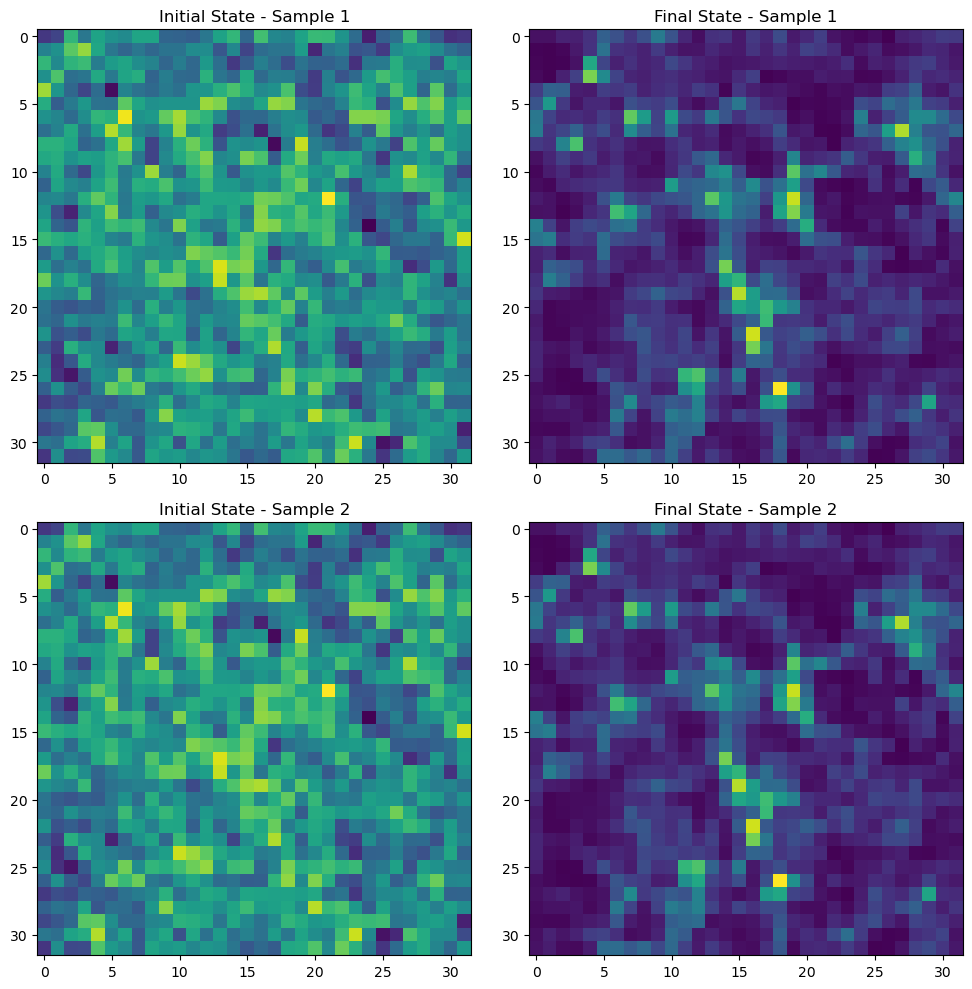

In [7]:
# Selecting a 2D slice (e.g., the first slice along the third dimension)
initial_state_slice_1 = initial_state[0][..., 0]
final_state_slice_1 = final_state[0][..., 0]

initial_state_slice_2 = initial_state[1][..., 0]
final_state_slice_2 = final_state[1][..., 0]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

# Initial state, sample 1
axes[0, 0].imshow(initial_state_slice_1, cmap='viridis')
axes[0, 0].set_title("Initial State - Sample 1")

# Final state, sample 1
axes[0, 1].imshow(final_state_slice_1, cmap='viridis')
axes[0, 1].set_title("Final State - Sample 1")

# Initial state, sample 2
axes[1, 0].imshow(initial_state_slice_2, cmap='viridis')
axes[1, 0].set_title("Initial State - Sample 2")

# Final state, sample 2
axes[1, 1].imshow(final_state_slice_2, cmap='viridis')
axes[1, 1].set_title("Final State - Sample 2")

plt.tight_layout()
plt.show()

In [8]:
# loading the model
vnet_model = load_model('./vnet_experiment_3_saved_data/150K/vnet_150K_260124.hdf5')

In [9]:
sample1, sample2 = initial_state[0], initial_state[1]

In [10]:
# special test sample - processing
sample1_processed = remove_center_and_fill(sample1, fill_value=0)
if sample1_processed.ndim == 3:
    sample1_processed = np.expand_dims(sample1_processed, axis=-1)

sample1_processed = np.reshape(sample1_processed, (1, *sample1_processed.shape))

In [12]:
if sample2.ndim == 3:
    sample2 = np.expand_dims(sample2, axis=-1)

sample2_processed = np.reshape(sample2, (1, *sample2.shape))

In [13]:
# y_sample1 = np.reshape(final_state[0], (*final_state[0].shape, 1))
# y_sample2 = np.reshape(final_state[1], (*final_state[1].shape, 1))

In [20]:
y_sample1 = final_state[0]
y_sample2 = final_state[1]

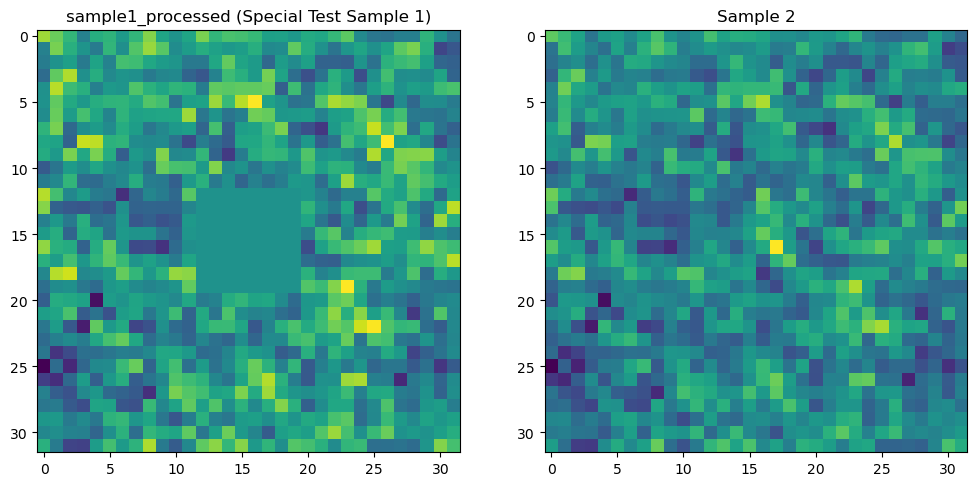

In [15]:
# Comparing both the samples
plt.figure(figsize=(12, 6))

# slice of sample1_processed (it is a 3D voxel)
plt.subplot(1, 2, 1)
plt.imshow(sample1_processed[0, :, :, sample1_processed.shape[3] // 2, 0], cmap='viridis')
plt.title('sample1_processed (Special Test Sample 1)')

# another random sample
plt.subplot(1, 2, 2)
plt.imshow(sample2_processed[0, :, :, sample2_processed.shape[3] // 2, 0], cmap='viridis')
plt.title('Sample 2')

plt.show()

## 3 panel plot processing

In [16]:
sample1_prediction = vnet_model.predict(sample1_processed)

2024-01-28 23:08:36.363458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


In [17]:
sample2_prediction = vnet_model.predict(sample2_processed)

In [34]:
#plot-1
slice_idx = sample1_prediction.shape[3] // 2
reconstructed = sample1_prediction[0, :, :, slice_idx, 0]

# plot-2
difference = y_sample1[:, :, y_sample1.shape[2] // 2] - reconstructed

# plot-3
slice_idx_2 = sample2_prediction.shape[3] // 2
reconstructed_2 = sample2_prediction[0, :, :, slice_idx_2, 0]

sum_plot = reconstructed_2 + (difference)

In [35]:
reconstructed.shape, difference.shape, sample2_prediction.shape, sum_plot.shape

((32, 32), (32, 32), (1, 32, 32, 32, 1), (32, 32))

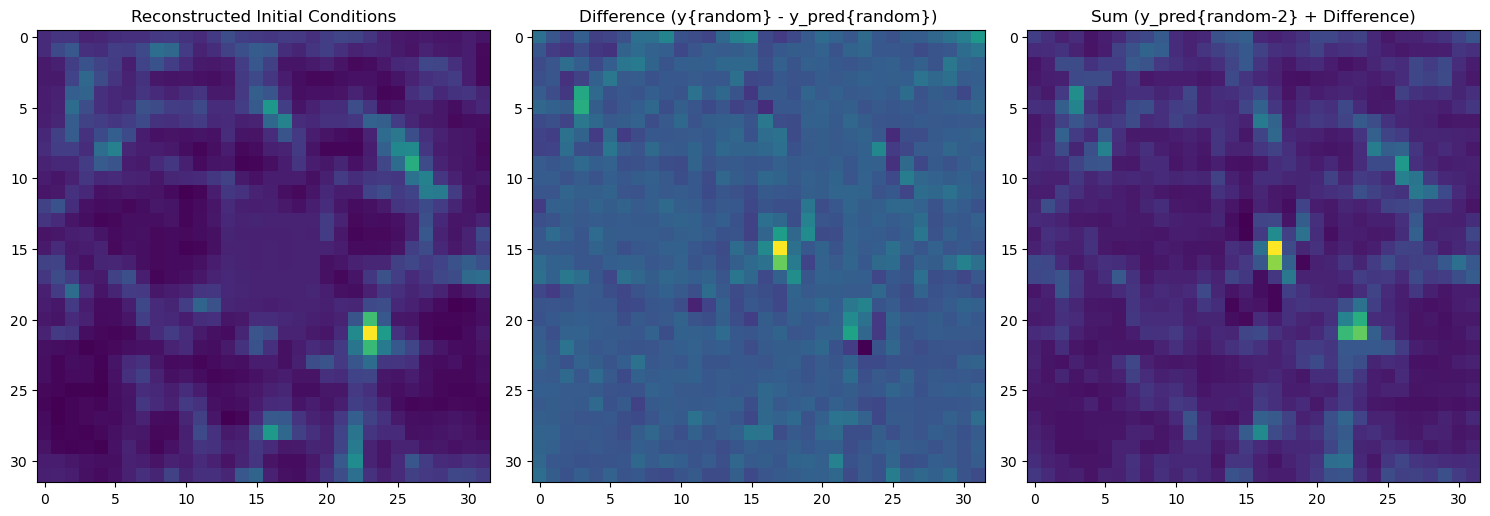

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(reconstructed, cmap='viridis')
axes[0].set_title('Reconstructed Initial Conditions')

axes[1].imshow(difference, cmap='viridis')
axes[1].set_title('Difference (y{random} - y_pred{random})')

axes[2].imshow(sum_plot, cmap='viridis')
axes[2].set_title('Sum (y_pred{random-2} + Difference)')

plt.tight_layout()
plt.show()


# Script Complete